# TFIM 分割後の状態と分割前(t=0)の状態とのFidelity

In [45]:
import qutip as qt
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.gridspec import GridSpec

In [ ]:
# ========= キャッシュ付きヘルパ =========

@lru_cache(maxsize=None)
def get_ops(N):
    """Nだけで決まる演算子たち"""
    cut_pos = N // 2 - 1
    sx, sz = qt.sigmax(), qt.sigmaz()
    I2 = qt.qeye(2)

    def op_at(i, op):
        return qt.tensor([op if k == i else I2 for k in range(N)])

    Sx = [op_at(i, sx) for i in range(N)]
    Sz = [op_at(i, sz) for i in range(N)]

    def H_exchange(i):
        return Sz[i] * Sz[i+1]

    Hcut_unit   = H_exchange(cut_pos)
    Hex_rest_unit = sum(H_exchange(i) for i in range(N-1) if i != cut_pos)
    Hhx_unit    = sum(Sx[i] for i in range(N))

    left_sites = list(range(N//2))
    return Hcut_unit, Hex_rest_unit, Hhx_unit, left_sites


@lru_cache(maxsize=None)
def get_psi0(N, J, hx):
    """(N, J, hx)で決まる初期基底状態"""
    Hcut_unit, Hex_rest_unit, Hhx_unit, _ = get_ops(N)
    H_full = -J * (Hcut_unit + Hex_rest_unit) - hx * Hhx_unit
    _, psi0 = H_full.groundstate(sparse=True)
    return psi0

# シミュレーション関数
# ========= メイン: Tcut ごとの時間発展 =========

def simulate(N, J, hx, Tcut):
    Hcut_unit, Hex_rest_unit, Hhx_unit, _ = get_ops(N)
    psi0 = get_psi0(N, J, hx)

    # Tcut=0 は「そもそも切ってないので完全一致」として即返す
    if Tcut == 0.0:
        return 1.0

    # H(t) = H_static + (-J * Hcut_unit) * ramp(t)
    H_static = -J * Hex_rest_unit - hx * Hhx_unit

    def ramp(t, Tcut):
        if Tcut <= 0.0:
            return 0.0 if t > 0.0 else 1.0
        if t <= 0.0:
            return 1.0
        if t >= Tcut:
            return 0.0
        return 1.0 - t / Tcut

    Ht = [H_static, [-J * Hcut_unit, lambda t, args: ramp(t, Tcut)]]

    # 0〜Tcut を分割（最後の点だけ使う）
    tlist = np.linspace(0.0, Tcut, 101)

    opts = qt.Options(
        method='bdf',      # ← これが効くようにする
        rtol=1e-6,
        atol=1e-8,
        nsteps=200000,
        store_states=True,
        store_final_state=True,
        progress_bar=None,
    )

    result = qt.sesolve(Ht, psi0, tlist, options=opts)

    psi_init = result.states[0]
    psi_final = result.states[-1]

    overlap = psi_final.overlap(psi_init)    # <psi_final | psi_init>
    fid = float(abs(overlap))                # 今は |…| にしている
    return fid

N is 4
Tcut is 0.0
Tcut is 200.0
Tcut is 400.0
Tcut is 600.0
Tcut is 800.0
Tcut is 1000.0
Tcut is 1200.0
Tcut is 1400.0
Tcut is 1600.0
Tcut is 1800.0
Tcut is 2000.0
Tcut is 2200.0
Tcut is 2400.0
Tcut is 2600.0
Tcut is 2800.0
Tcut is 3000.0
Tcut is 3200.0
Tcut is 3400.0
Tcut is 3600.0
Tcut is 3800.0
Tcut is 4000.0
Tcut is 4200.0
Tcut is 4400.0
Tcut is 4600.0
Tcut is 4800.0
Tcut is 5000.0
Tcut is 5200.0
Tcut is 5400.0
Tcut is 5600.0
Tcut is 5800.0
Tcut is 6000.0
Tcut is 6200.0
Tcut is 6400.0
Tcut is 6600.0
Tcut is 6800.0
Tcut is 7000.0
Tcut is 7200.0
Tcut is 7400.0
Tcut is 7600.0
Tcut is 7800.0
Tcut is 8000.0
Tcut is 8200.0
Tcut is 8400.0
Tcut is 8600.0
Tcut is 8800.0
Tcut is 9000.0
Tcut is 9200.0
Tcut is 9400.0
Tcut is 9600.0
Tcut is 9800.0
Tcut is 10000.0
N is 6
Tcut is 0.0
Tcut is 200.0
Tcut is 400.0
Tcut is 600.0
Tcut is 800.0
Tcut is 1000.0
Tcut is 1200.0
Tcut is 1400.0
Tcut is 1600.0
Tcut is 1800.0
Tcut is 2000.0
Tcut is 2200.0
Tcut is 2400.0
Tcut is 2600.0
Tcut is 2800.0
Tcut is 3

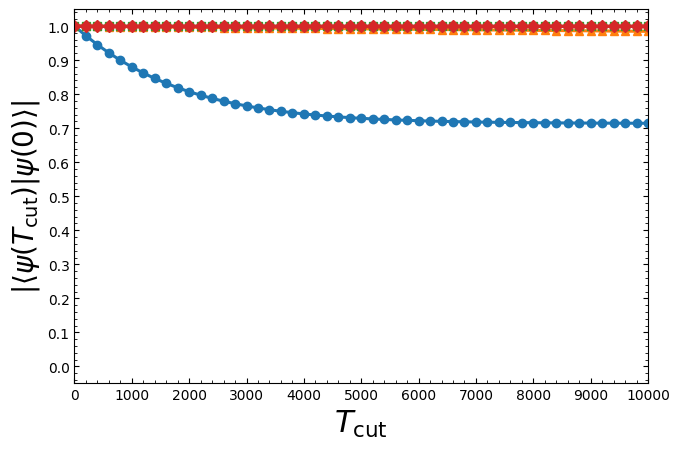

In [89]:
# ========= プロット =========

hx = 0.1
N_list = [4, 6, 8, 10]
Tcut_list = np.linspace(0.0, 10000.0, 51)
J = 1.0

markers = ['o', '^', 's', 'D', 'x']

fig, ax = plt.subplots(figsize=(6.9, 4.6))
nstamp = '-'.join(map(str, N_list))

for i, N in enumerate(N_list):
    fid_list = []
    mk = markers[i % len(markers)]
    print(f"N is {N}")
    for Tcut in Tcut_list:
        fid = simulate(N=N, J=J, hx=hx, Tcut=Tcut)
        print(f"Tcut is {Tcut}")
        fid_list.append(fid)

    ax.plot(
        Tcut_list, fid_list,
        marker=mk,
        linewidth=2.2,
        markersize=6.0,
        label=rf"$N={N}$",
    )

ax.set_xlim(Tcut_list.min(), Tcut_list.max())
ax.set_ylim(-0.05, 1.05)  # |overlap| なので 0〜1
ax.set_xlabel(r"$T_{\rm cut}$", fontsize=22)
ax.set_ylabel(r"$| \langle\psi(T_{\rm cut})|\psi(0)\rangle | $", fontsize=20)

ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.xaxis.set_minor_locator(MultipleLocator(500))

ax.minorticks_on()
ax.tick_params(which='both', direction='in', top=True, right=True)
# ax.legend(frameon=False, fontsize=14)
fig.tight_layout()

OUTDIR = Path("../charts/tfim2")
OUTDIR.mkdir(parents=True, exist_ok=True)
fig.savefig(OUTDIR / f"fid_init_fin_N{nstamp}_hx{hx}.pdf", bbox_inches="tight", dpi=300)

plt.show()